In [2]:
import pandas as pd

In [3]:
df = pd.read_csv('CosciaRios2012_DataBase.csv')

In [15]:
df_2010 = df[df['Year'] == 2010]

#df_2010_empty = df_2010[(df_2010['Beltran_Leyva'] == 0) & (df_2010['Beltran_Leyva_Family'] == 0) & (df_2010['Familia'] == 0) & (df_2010['Golfo'] == 0) & (df_2010['Juarez'] == 0) & (df_2010['Sinaloa'] == 0) & (df_2010['Sinaloa_Family'] == 0) & (df_2010['Tijuana'] == 0)& (df_2010['Zetas'] == 0)& (df_2010['Otros'] == 0)] 


In [17]:
df_2010

,Code,State,Year,Beltran_Leyva,Beltran_Leyva_Family,Familia,Golfo,Juarez,Sinaloa,Sinaloa_Family,Tijuana,Zetas,Otros
20,1001,1,2010,0,0,1,0,1,0,0,0,1,0
41,1002,1,2010,0,0,1,0,0,1,0,0,0,0
62,1003,1,2010,0,0,0,0,0,0,0,0,1,0
83,1004,1,2010,0,0,0,0,0,0,0,0,0,0
104,1005,1,2010,0,0,0,0,0,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
51491,32053,32,2010,0,0,0,0,0,0,0,0,0,0
51512,32054,32,2010,0,0,0,0,0,0,0,0,0,0
51533,32055,32,2010,0,0,0,0,0,0,0,0,1,0
51554,32056,32,2010,0,0,1,1,0,1,0,0,1,0


In [41]:
import pandas as pd
import networkx as nx
from itertools import combinations

# Assuming df_2010 is already loaded
df = df_2010.copy()

# Select only cartel columns (excluding Code, State, Year)
cartel_cols = df.columns.difference(['Code', 'State', 'Year'])

# Initialize empty graph
G = nx.Graph()

# Add all municipalities as nodes
G.add_nodes_from(df['Code'])

# For each cartel/family column, connect all municipalities where it is present
for cartel in cartel_cols:
    present = df.loc[df[cartel] == 1, 'Code']
    # Add edges between all pairs of municipalities with that cartel
    for u, v in combinations(present, 2):
        # Add edge (and optionally keep track of which cartel(s) caused it)
        if G.has_edge(u, v):
            G[u][v]['cartels'].add(cartel)
        else:
            G.add_edge(u, v, cartels={cartel})

# Optional: Add attribute with number of shared cartels
for u, v, data in G.edges(data=True):
    data['weight'] = len(data['cartels'])

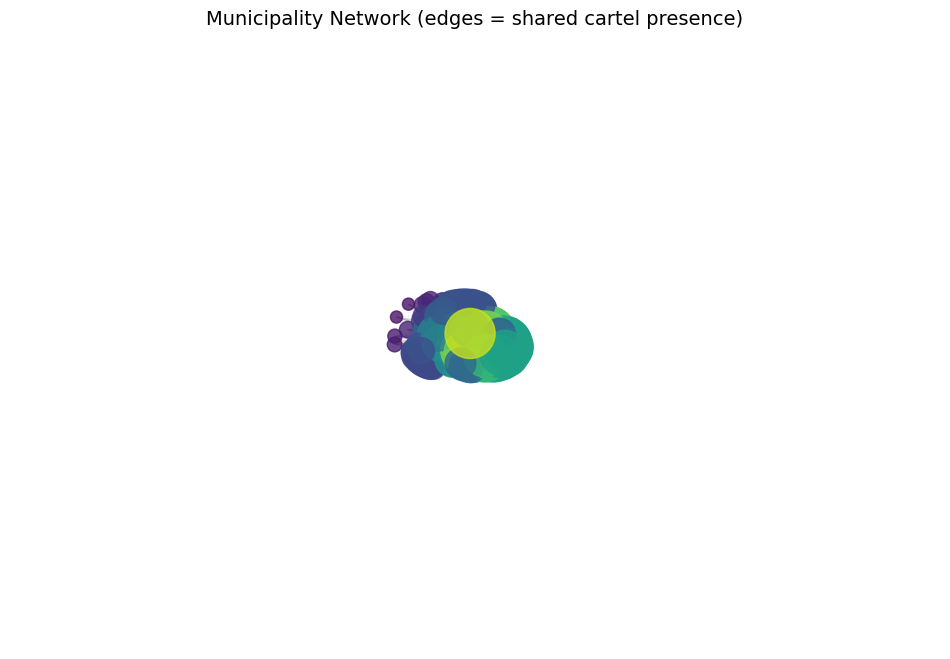

In [22]:
import networkx as nx
import matplotlib.pyplot as plt
import pandas as pd

# Using the G you already built:
# G = ...

# Compute node degree for size scaling
degree_dict = dict(G.degree())

# Define layout (spring)
pos = nx.spring_layout(G, k=0.2, iterations=50, seed=42)

# Draw nodes
plt.figure(figsize=(12, 8))
nx.draw_networkx_nodes(
    G, pos,
    node_size=[v*2 for v in degree_dict.values()],
    node_color=list(degree_dict.values()),
    cmap='viridis',
    alpha=0.8
)

# Draw edges with transparency
nx.draw_networkx_edges(
    G, pos,
    width=0.2,
    alpha=0.2,
    edge_color='gray'
)

plt.title("Municipality Network (edges = shared cartel presence)", fontsize=14)
plt.axis('off')
plt.show()

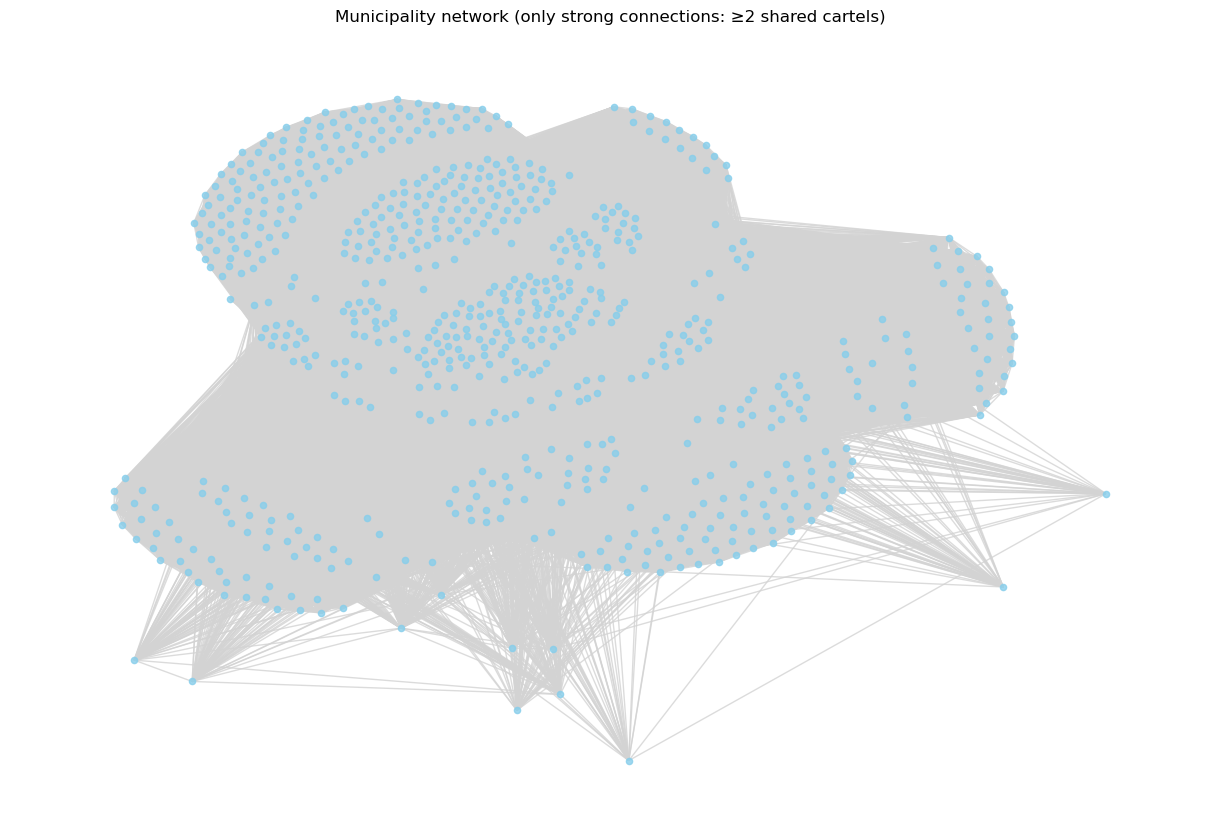

In [45]:
# Keep only edges with weight ≥ 2 (i.e., share at least two cartels)
edges_strong = [(u, v) for u, v, d in G.edges(data=True) if d['weight'] >= 1]
G_strong = G.edge_subgraph(edges_strong)

pos = nx.spring_layout(G_strong, k=0.4, iterations=60, seed=42)
plt.figure(figsize=(12, 8))
nx.draw(
    G_strong, pos,
    node_size=20,
    node_color='skyblue',
    edge_color='lightgray',
    alpha=0.8
)
plt.title("Municipality network (only strong connections: ≥2 shared cartels)")
plt.show()

/var/folders/zr/smdr6v5n5n9bqzbn6p1437880000gn/T/ipykernel_7344/2092446182.py:8: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  nx.draw_networkx_nodes(G, pos, node_color=colors, cmap=cm.get_cmap('tab10', max(colors)+1), node_size=20)


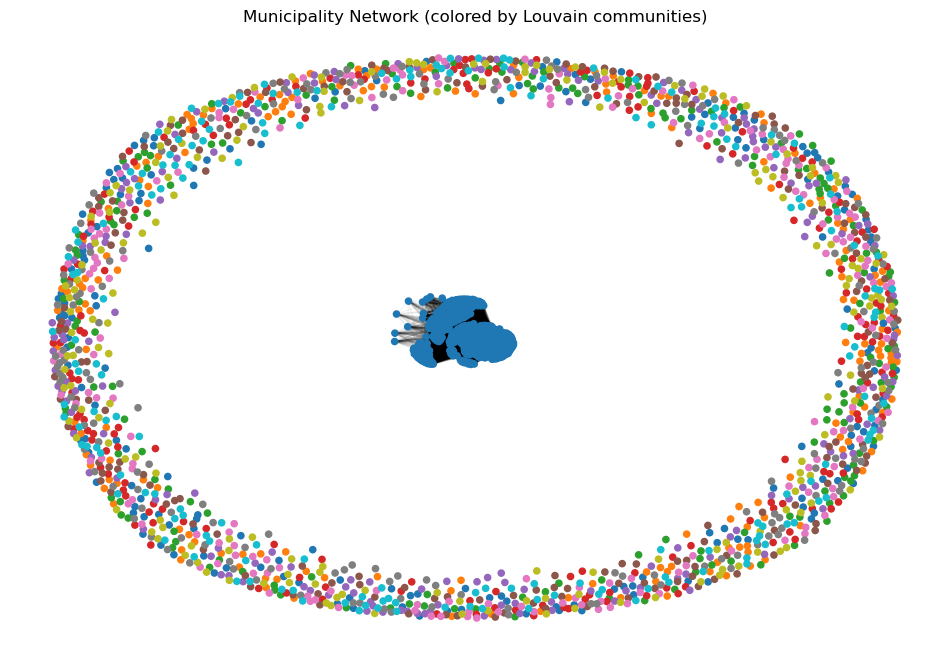

In [40]:
import community.community_louvain as community_louvain
import matplotlib.cm as cm

partition = community_louvain.best_partition(G)
colors = [partition[n] for n in G.nodes()]

plt.figure(figsize=(12, 8))
nx.draw_networkx_nodes(G, pos, node_color=colors, cmap=cm.get_cmap('tab10', max(colors)+1), node_size=20)
nx.draw_networkx_edges(G, pos, alpha=0.05)
plt.title("Municipality Network (colored by Louvain communities)")
plt.axis('off')
plt.show()

/var/folders/zr/smdr6v5n5n9bqzbn6p1437880000gn/T/ipykernel_7344/319876600.py:42: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap('tab20', 32)  # you can also try 'tab20b' or 'nipy_spectral'


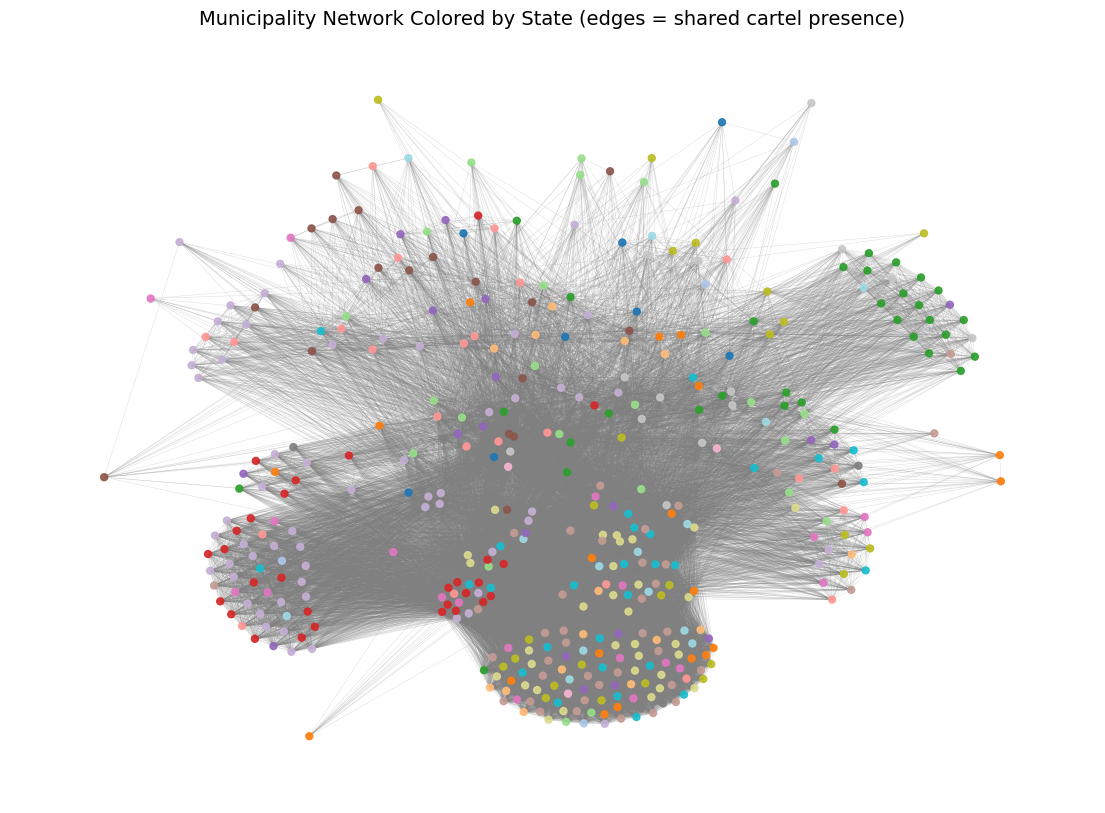

In [47]:
import pandas as pd
import networkx as nx
from itertools import combinations
import matplotlib.pyplot as plt
import matplotlib.cm as cm

# --- 1. Build graph from df_2010 ---
df = df_2010.copy()

# Select only cartel columns (excluding Code, State, Year)
cartel_cols = df.columns.difference(['Code', 'State', 'Year'])

# Initialize graph
G = nx.Graph()
G.add_nodes_from(df['Code'])

# For each cartel/family column, connect municipalities where it is present
for cartel in cartel_cols:
    present = df.loc[df[cartel] == 1, 'Code']
    for u, v in combinations(present, 2):
        if G.has_edge(u, v):
            G[u][v]['cartels'].add(cartel)
        else:
            G.add_edge(u, v, cartels={cartel})

# Add weight = number of shared cartels
for u, v, data in G.edges(data=True):
    data['weight'] = len(data['cartels'])

# --- 2. Filter to strong edges (>= 1 or >= 2 shared cartels) ---
edges_strong = [(u, v) for u, v, d in G.edges(data=True) if d['weight'] >= 2]
G_strong = G.edge_subgraph(edges_strong).copy()

# --- 3. Color nodes by State ---
# Map each Code to its State
state_map = df.set_index('Code')['State'].to_dict()

# Create color values for nodes
state_values = [state_map.get(node, 0) for node in G_strong.nodes()]

# Create a colormap (32 discrete colors for states)
cmap = cm.get_cmap('tab20', 32)  # you can also try 'tab20b' or 'nipy_spectral'

# --- 4. Plot network ---
plt.figure(figsize=(14, 10))
pos = nx.spring_layout(G_strong, k=0.4, iterations=60, seed=42)

nx.draw_networkx_nodes(
    G_strong,
    pos,
    node_size=25,
    node_color=state_values,
    cmap=cmap,
    alpha=0.9
)

nx.draw_networkx_edges(
    G_strong,
    pos,
    width=0.3,
    alpha=0.3,
    edge_color='gray'
)

plt.title("Municipality Network Colored by State (edges = shared cartel presence)", fontsize=14)
plt.axis('off')
plt.show()


/var/folders/zr/smdr6v5n5n9bqzbn6p1437880000gn/T/ipykernel_7344/3259227867.py:44: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap('tab20', max(communities) + 1)


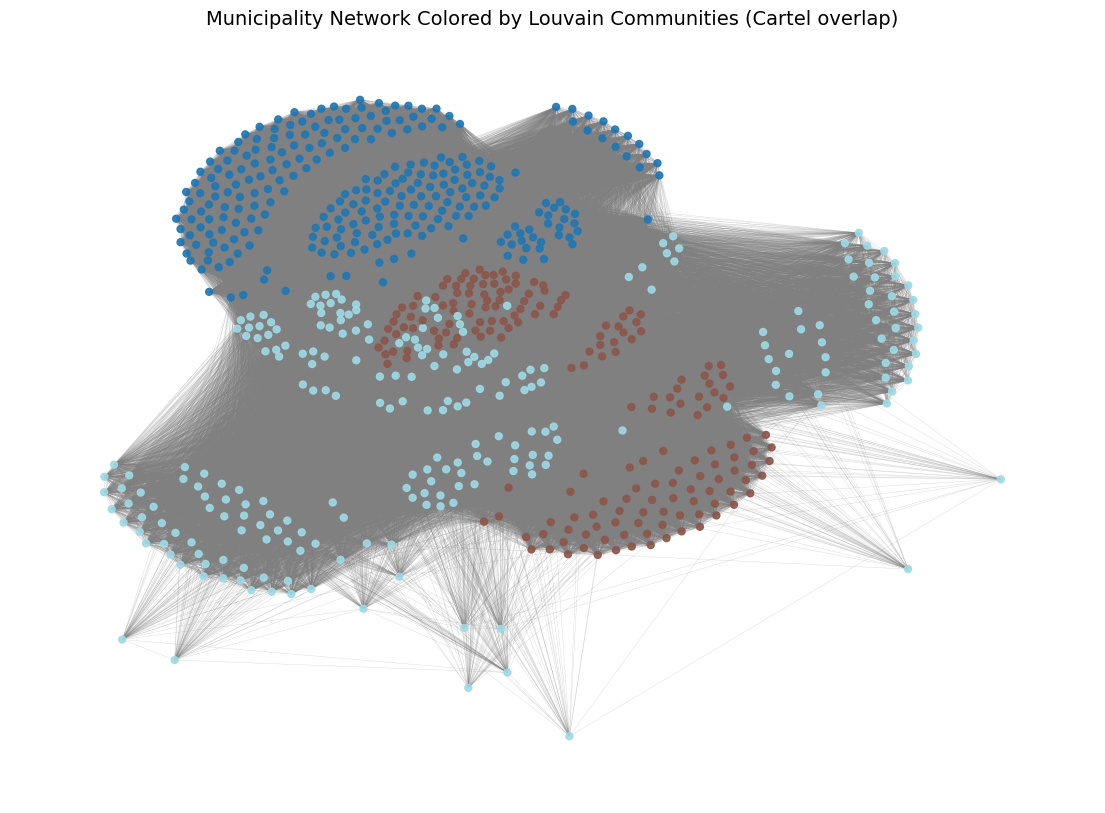

In [50]:
import pandas as pd
import networkx as nx
from itertools import combinations
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import community.community_louvain as community_louvain  # make sure it's python-louvain

# --- 1. Build graph from df_2010 ---
df = df_2010.copy()

cartel_cols = df.columns.difference(['Code', 'State', 'Year'])

G = nx.Graph()
G.add_nodes_from(df['Code'])

for cartel in cartel_cols:
    present = df.loc[df[cartel] == 1, 'Code']
    for u, v in combinations(present, 2):
        if G.has_edge(u, v):
            G[u][v]['cartels'].add(cartel)
        else:
            G.add_edge(u, v, cartels={cartel})

for u, v, data in G.edges(data=True):
    data['weight'] = len(data['cartels'])

# --- 2. Keep only strong edges ---
edges_strong = [(u, v) for u, v, d in G.edges(data=True) if d['weight'] >= 1]
G_strong = G.edge_subgraph(edges_strong).copy()

# --- 3. Detect communities (Louvain) ---
partition = community_louvain.best_partition(G_strong, weight='weight')

# Extract community numbers in same node order
communities = [partition[node] for node in G_strong.nodes()]

# --- 4. Visualization ---
plt.figure(figsize=(14, 10))

# Layout (spring works well; Kamada-Kawai is good too)
pos = nx.spring_layout(G_strong, k=0.4, iterations=60, seed=42)

# Color map based on number of communities
cmap = cm.get_cmap('tab20', max(communities) + 1)

# Draw nodes and edges
nx.draw_networkx_nodes(
    G_strong,
    pos,
    node_size=25,
    node_color=communities,
    cmap=cmap,
    alpha=0.9
)

nx.draw_networkx_edges(
    G_strong,
    pos,
    width=0.3,
    alpha=0.3,
    edge_color='gray'
)

plt.title("Municipality Network Colored by Louvain Communities (Cartel overlap)", fontsize=14)
plt.axis('off')
plt.show()


In [51]:
deg_cent = nx.degree_centrality(G_strong)
top_degree = sorted(deg_cent.items(), key=lambda x: x[1], reverse=True)[:10]
print("Top municipalities by degree centrality:")
for code, score in top_degree:
    print(f"{code}: {score:.3f}")


Top municipalities by degree centrality:
8037: 0.999
17007: 0.968
17018: 0.968
10007: 0.966
12001: 0.962
25011: 0.956
22014: 0.953
15033: 0.945
15058: 0.928
19009: 0.918
